# High performance computing in Python

In this tutorial, you will learn how to use different Python libraries, compatible with Numpy, to reduce the computational time for multidimensional array operation. You will also check how to use a tiling strategy to manage raster datasets that does not fit in memory. At the end, you will combine these approaches in a processing workflow highly optimized for a single tile (chunk of raster data), but also able to process multiple tiles in parallel using available the CPU cores.

Additionally to Numpy, the follow libraries/modules will be used during the tutorial:
* [Bootleneck](https://bottleneck.readthedocs.io/en/latest/): Collection of Numpy fast functions written in C, which are able to manage NaN values,
* [NumExpr](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/index.html): Numeric expression evaluator memory optimized,
* [Numba](http://numba.pydata.org/): Just-in-time Python compiler able to translate user defined numerical algorithms in C or FORTRAN,
* [eumap.parallel](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.parallel.utils.html#module-eumap.parallel.utils): eumap implementation for multi-core parallelization strategies, written purely in Python.

## Python environment & libraries

During this tutorial we will use several functions from [eumap](https://eumap.readthedocs.io), a library that can be installed through [Conda/Pip](https://eumap.readthedocs.io/en/latest/index.html#conda), or used directly inside the Docker container [opengeohub/pygeo-ide](https://hub.docker.com/r/opengeohub/pygeo-ide).

However, if you are running this tutorial in **Google Colab**, use the following line to install eumap properly:

In [ ]:
!pip install -e 'git+https://gitlab.com/geoharmonizer_inea/eumap.git@colab_deps#egg=eumap[full]'

Considering that the dataset used by the tutorial will be retrieved directly from the [ODSE SpatioTemporal Asset Catalog (STAC)](https://stac.opendatascience.eu/), it's necessary install the [pystac library](https://pystac.readthedocs.io/en/stable/index.html):

In [ ]:
!pip install pystac

After that, let's import some python modules / functions:

In [7]:
from pathlib import Path
import numpy as np
import rasterio

from eumap.misc import find_files
from eumap.raster import read_rasters, save_rasters
from eumap import plotter 

import pystac

## Dataset preparation

There are several analysis ready raster layers, perfected stacked and publicly available in ODSE STAC, and for this tutorial we will work with the [**Annual land use and land cover at 30 m (2000–2020)**](https://stac.opendatascience.eu/lcv_landcover.hcl_lucas.corine.eml/collection.json).

Use the following code to create a **connection** with the ODSE STAC, retrieve all the **items** from a specific collection and save all **asset URLs** in a list:

In [2]:
STAC_URL = 'https://s3.eu-central-1.wasabisys.com/stac/odse/catalog.json'

RED_COLLECTION = 'lcv_red_landsat.glad.ard'
RED_ASSET = 'red_p50'

NIR_COLLECTION = 'lcv_nir_landsat.glad.ard'
NIR_ASSET = 'nir_p50'

cat = pystac.Catalog.from_file(STAC_URL)

red_urls = []
for item in cat.get_child(RED_COLLECTION).get_all_items():
    red_urls.append(item.assets[RED_ASSET].href)
    
nir_urls = []
for item in cat.get_child(NIR_COLLECTION).get_all_items():
    nir_urls.append(item.assets[NIR_ASSET].href)

Let's check what we have in ``raster_urls``:

In [3]:
print(f'First Red layer: {red_urls[0]}')
print(F'Last Red layer: {red_urls[len(red_urls)-1]}')
print('')
print(f'First NIR layer: {nir_urls[0]}')
print(F'Last NIR layer: {nir_urls[len(nir_urls)-1]}')

First Red layer: https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_1999.12.02..2000.03.20_eumap_epsg3035_v1.1.tif
Last Red layer: https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2020.09.13..2020.12.01_eumap_epsg3035_v1.1.tif

First NIR layer: https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_nir_landsat.glad.ard_p50_30m_0..0cm_1999.12.02..2000.03.20_eumap_epsg3035_v1.1.tif
Last NIR layer: https://s3.eu-central-1.wasabisys.com/eumap/lcv/lcv_nir_landsat.glad.ard_p50_30m_0..0cm_2020.09.13..2020.12.01_eumap_epsg3035_v1.1.tif


Every URL of this list refers to a Cloud-Optimized GeoTIFF (COG) covering the entire Europe, which give us the possibility to draw **a polygon** in a specific region of interest *(inside Europe)* using an interactive map provided by [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/). 

**Please make sure to select a small area covering, for example, a municipally** and not a entire country:

In [4]:
from ipyleaflet import Map, basemaps, basemap_to_tiles, DrawControl, LayersControl

m = Map(center=(51.98, 5.65), zoom = 4, basemap= basemaps.OpenStreetMap.Mapnik)

draw_control = DrawControl()
draw_control.rectangle = {
    "shapeOptions": {
        "color": "#ff0000",
        "fillOpacity": 0,
        "opacity": 1
    }
}

m.add_control(draw_control)
m.add_control(LayersControl())

m

Map(center=[51.98, 5.65], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_ou…

You can now select the feature from `DrawControl.data` object and get its bounds.

In [5]:
from shapely.geometry import shape
geometry = shape(draw_control.data[-1]['geometry'])
bounds = geometry.bounds
bounds

(5.552902, 52.008304, 5.907211, 52.139981)

ipyleaflet.DrawControl defines geometries in the WGS84 CRS, so we'll first transform them to ETRS89/LAEA before we can define a Window to read the COGs.

In [8]:
from pyproj import Transformer
from rasterio.windows import Window, from_bounds

base_raster = rasterio.open(red_urls[0])

transformer = Transformer.from_crs("epsg:4326", base_raster.crs, always_xy=True)
left, bottom = transformer.transform(bounds[0], bounds[1])
right, top = transformer.transform(bounds[2], bounds[3])

window = from_bounds(left, bottom, right, top, base_raster.transform)
print(left, bottom, right, top)
print(window)

4015857.570723624 3220236.7729838225 4040962.3864708957 3233444.1176892067
Window(col_off=103861.91902412078, row_off=74218.86274369313, width=836.8271915757505, height=440.24482351279585)


In [9]:
red_data, _ = read_rasters(raster_files=red_urls, spatial_win=window, verbose=True)
nir_data, _ = read_rasters(raster_files=nir_urls, spatial_win=window, verbose=True)

[15:55:07] Reading 84 raster files using 4 workers
[15:55:32] Reading 84 raster files using 4 workers


In [11]:
red_rasters = [ Path('ODSE_workdir').joinpath('red').joinpath(Path(url).name) for url in red_urls ]
red_rasters = save_rasters(fn_base_raster=red_urls[0], fn_raster_list=red_rasters, data=red_data, spatial_win=window, verbose=True)

nir_rasters = [ Path('ODSE_workdir').joinpath('nir').joinpath(Path(url).name) for url in nir_urls ]
nir_rasters = save_rasters(fn_base_raster=nir_urls[0], fn_raster_list=nir_rasters, data=nir_data, spatial_win=window, verbose=True)

[15:56:27] Writing 84 raster files using 4 workers
[15:56:28] Writing 84 raster files using 4 workers


## Array Reduction

First, you will optimize a array reduction over the Landsat data, one of the [temporal datasets](01_introduction_to_odse_datasets) produced by ODSE. For the scope of this tutorial, an array reduction is primarily a [Numpy operation]() over one or more dimensions of a multidimensional array, producing an output with less data than the input.

Here is a book example to calculate the maximum value over a 2D array:

In [12]:
in_data = np.array([[1,2], [3,1]])
out_data = np.max(in_data, axis=0)

print(f'input_shape={in_data.shape} output_shape={out_data.shape}')
print(f'result= {out_data}')

input_shape=(2, 2) output_shape=(2,)
result= [3 2]


Now it's time to work with real data. Let's read the Landsat rasters, specifically the red band and percentile 50. 

Be aware with the ``dtype`` and ``size`` of the loaded array

In [13]:
def _info(data):
    return f' shape={data.shape} dtype={data.dtype} size={(data.nbytes / 1024 / 1024):.2f} MB'

raster_files = red_rasters
red_data, _ = read_rasters(raster_files=raster_files, dtype="float32")
print(_info(red_data))

 shape=(440, 836, 84) dtype=float32 size=117.87 MB


The standard way of implement an array reduction is using the [statistics functions](https://numpy.org/doc/stable/reference/routines.statistics.html) available in Numpy. In the context of the Earth Observation data it is better to use ``nan*`` functions, which ignore the nodata (``np.nan``) during the calculation. This specific dataset (tile ``5606``) were prepared by [ODSE](https://opendatascience.eu/) so that the cloud and cloud shadow pixels were removed and all nodata pixels over the [land mask](https://gitlab.com/geoharmonizer_inea/spatial-layers#the-land-mask) were gapfilled. Although these raster layers have a nodata values only over the ocean water (the tile ``14580`` has no nodata at all), that's not the case for the most part of publicly available satellite images.

To evaluate the performance between the different libraries, let's use the [timeit magic cell](https://ipython.readthedocs.io/en/stable/interactive/magics.html#magic-timeit), provided by [ipython](https://ipython.readthedocs.io), with five repetitions and producing a time estimate based in the average and standard deviation of the individual executions.

In [14]:
time_np =  %timeit -r 5 -o np.nanmedian(red_data, axis=(2))

1.97 s ± 8.21 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Now let's evaluate the performance of [Bottleneck](https://bottleneck.readthedocs.io/en/latest/) executing the same operation:

In [15]:
import bottleneck as bn
time_bn = %timeit -r 5 -o bn.nanmedian(red_data, axis=(2))

406 ms ± 2.09 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


This is a **remarkable improvement**! Imagine this performance difference over 7000x more data, what is actually almost the number of [tiles](https://gitlab.com/geoharmonizer_inea/spatial-layers#standard-tiling-system) necessary to cover the Continental Europe.

However, it's important to check if the data produced by the two libraries is exactly the same using the [array_equal](https://numpy.org/doc/stable/reference/generated/numpy.array_equal.html) function.

In [16]:
red_med_bn = bn.nanmedian(red_data, axis=(2))
red_med_np = np.nanmedian(red_data, axis=(2))

print(f'(red_med_np == red_med_bn) = {np.array_equal(red_med_np, red_med_bn, equal_nan=True)}')

(red_med_np == red_med_bn) = True


Numba is a [more complex library](https://numba.readthedocs.io/en/stable/user/index.html), which allows different possibilities of optimizations. Here we will be restrict to the basic usage of a [``@jit decorator``](https://numba.readthedocs.io/en/stable/user/jit.html#signature-specifications) in ``nopython`` mode and with automatic parallelization. Nevertheless, Numba doesn't support [the ``axis`` argument for nanmedian](https://numba.pydata.org/numba-doc/dev/reference/numpysupported.html), used to reduce the time dimension in Numpy and [Bottleneck](https://bottleneck.readthedocs.io/en/latest/). You can solve it by reshaping the input array into two dimensions.

In [17]:
last_dim = red_data.shape[-1]
print(f'Numpy/Bottleneck input shape: {red_data.shape}')
print(f'Numba input shape: {red_data.reshape(-1,last_dim).shape}')

Numpy/Bottleneck input shape: (440, 836, 84)
Numba input shape: (367840, 84)


After that, you are ready to check the performance of [Numba](https://numba.readthedocs.io/en/stable/user/index.html):

In [18]:
from numba import prange, jit

last_dim = red_data.shape[-1]
out_shape = red_data.shape[:-1]

@jit(parallel=True)
def _reduce(data):
    
    x = np.zeros(len(data))
    for i in prange(data.shape[0]):
        x[i] = np.nanmedian(data[i])
    
    return x

time_nb = %timeit -r 5 -o _reduce(red_data.reshape(-1,last_dim)).reshape(out_shape)

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


106 ms ± 2.62 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


Don't forget to check the output consistency:

In [19]:
red_med_nb = _reduce(red_data.reshape(-1,last_dim)).reshape(out_shape)
print(f'(red_med_np == red_med_nb) = {np.array_equal(red_med_np, red_med_nb, equal_nan=True)}')

(red_med_np == red_med_nb) = True


You can also check the data using [eumap.plotter](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.plotter.html)

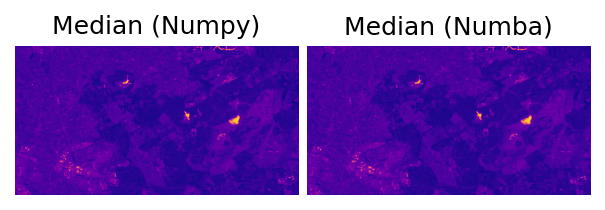

In [20]:
plotter.plot_rasters(red_med_np, red_med_nb, cmaps="plasma", figsize=5, titles=['Median (Numpy)', 'Median (Numba)'])

Now that you have all results, you can create a summary table using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html):

In [21]:
import pandas as pd
timeit_res = pd.DataFrame({
    'library':[ 'Numpy', 'Bootleneck', 'Numba' ], 
    'average':[ time_np.average, time_bn.average, time_nb.average ], 
    'std':[ time_np.stdev, time_bn.stdev, time_nb.stdev ], 
}).sort_values(by='average', ascending=True)

timeit_res

,library,average,std
2,Numba,0.105773,0.002618
1,Bootleneck,0.405916,0.002087
0,Numpy,1.973722,0.008208


## Numeric Operation

As second example, you will optimize a numeric operation over the same data (Landsat), however this time using the red and NIR band to derive a [spectral index](usgs.gov/core-science-systems/nli/landsat/landsat-surface-reflectance-derived-spectral-indices?qt-science_support_page_related_con=0#qt-science_support_page_related_con). You will perform a mathematical operation over two multidimensional arrays, deriving as result a third array with the same dimensions.

Here it is a book example for a multiplication of two 2D arrays:

In [22]:
in_data1 = np.array([[4,4], [4,4]])
in_data2 = np.array([[3,3], [3,3]])

out_data = in_data1 * in_data2

print(f'input1_shape={in_data1.shape} input2_shape={in_data2.shape} output_shape={out_data.shape}')
print('Result:')
print(out_data)

input1_shape=(2, 2) input2_shape=(2, 2) output_shape=(2, 2)
Result:
[[12 12]
 [12 12]]


Seeking to reduce the size of the data in memory, let's load just the first 10 years (first 40 images):

In [23]:
red_data, red_files = read_rasters(raster_files=red_rasters[0:40], dtype="float32")
nir_data, nir_files = read_rasters(raster_files=nir_rasters[0:40], dtype="float32")

print(_info(red_data))
print(_info(nir_data))

 shape=(440, 836, 40) dtype=float32 size=56.13 MB
 shape=(440, 836, 40) dtype=float32 size=56.13 MB


Using this two bands you will calculate the [Near-infrared Reflectance of Terrestrial Vegetation (NIRV)](https://www.science.org/doi/epdf/10.1126/sciadv.1602244), which is a new index for Earth Observation data that presents lower saturation effect and closer relation to gross primary productivity (GPP):

![image.png](https://gitlab.com/geoharmonizer_inea/odse-workshop-2022/-/raw/main/img/nirv.png?inline=true)

The NIRV calculation in Numpy is straightforward:

In [24]:
def _nirv(red, nir):
    return ( (nir - red) / (nir + red) ) * nir

time_nirv_np = %timeit -r 5 -o _nirv(red_data, nir_data)

91.9 ms ± 426 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


For Numba you can use the [``@vectorize`` decorator](https://numba.pydata.org/numba-doc/latest/user/vectorize.html), which implements the traditional [NumPy ufuncs](https://numpy.org/doc/stable/reference/ufuncs.html) in C, thus improving the executing performance:

In [25]:
from numba import vectorize, float32

@vectorize([float32(float32, float32)], nopython=True)
def _nirv_nb(red, nir):
    return ( (nir - red) / (nir + red) ) * nir

time_nirv_nb = %timeit -r 5 -o _nirv_nb(red_data, nir_data)

38.9 ms ± 528 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


If you compare the both result it should be exactly the same:

In [26]:
nirv_np = _nirv(red_data, nir_data)
nirv_nb = _nirv_nb(red_data, nir_data)

print(f'(nirv_np == nirv_nb) = {np.array_equal(nirv_np, nirv_nb, equal_nan=True)}')

(nirv_np == nirv_nb) = True


As expected, Numba performs better than Numpy, although at this time you will include a new library in the competition. [Numpexpr](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/index.html) runs over a virtual machine based on the iterator [``nditer``](https://numpy.org/doc/stable/reference/arrays.nditer.html), introduced in NumPy 1.6, which improves the memory usage for numeric operations and optimize the broadcasting and conversion related to multidimensional arrays.

The usage of Numexpr occurs through the [``evaluate``](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/user_guide.html#usage-notes) method, which supports [several functions/operations](https://numexpr.readthedocs.io/projects/NumExpr3/en/latest/user_guide.html#supported-functions):

In [27]:
import numexpr as ne

expression = '( (nir - red) / (nir + red) ) * nir'
params = { 'nir': nir_data, 'red': red_data }

time_nirv_ne = %timeit -r 5 -o ne.evaluate(expression, params, optimization='aggressive')

21.1 ms ± 458 µs per loop (mean ± std. dev. of 5 runs, 10 loops each)


Don't forget to check the consistency of the output:

In [28]:
nirv_ne = ne.evaluate(expression, params)
print(f'(nirv_np == nirv_ne) = {np.array_equal(nirv_np, nirv_ne, equal_nan=True)}')

(nirv_np == nirv_ne) = True


Time to produce the performance summary:

In [29]:
import pandas as pd
timeit_res = pd.DataFrame({
    'library':[ 'Numpy', 'Numexpr', 'Numba' ], 
    'average':[ time_nirv_np.average, time_nirv_ne.average, time_nirv_nb.average ], 
    'std':[ time_nirv_np.stdev, time_nirv_ne.stdev, time_nirv_nb.stdev ], 
}).sort_values(by='average', ascending=True)

timeit_res

,library,average,std
1,Numexpr,0.021090,0.000458
2,Numba,0.038945,0.000528
0,Numpy,0.091945,0.000426


Considering that you produced 40 NIRv images, you can use the follow function to visualize the result per year:

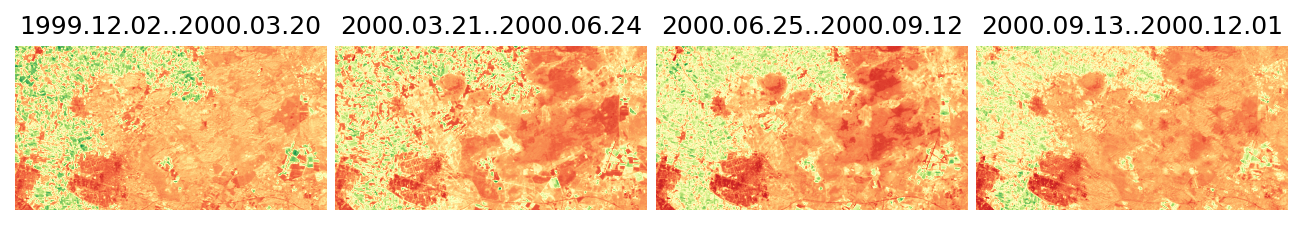

In [30]:
def plot_ts(data, raster_files, year, dt_position = 6):
    data_arr, title_arr = [], []
    
    for i in range(0, len(raster_files)):
        raster_dt = raster_files[i].stem.split('_')[dt_position]
        raster_year = raster_dt.split('..')[1].split('.')[0]
        
        if raster_year == str(year):
            data_arr.append(data[:,:,i])
            title_arr.append(raster_dt)
    
    plotter.plot_rasters(*data_arr, cmaps="RdYlGn", figsize=11, titles=title_arr)
    
plot_ts(nirv_nb, red_rasters, '2000')

Why not can save the NIRv images as GeoTIFF using [eumap.raster module](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.raster.save_rasters.html#eumap.raster.save_rasters), keeping the filename standard, and visualize them in [QGIS](https://www.qgis.org/en/site/):

In [31]:
nirv_files = [ Path('ODSE_workdir').joinpath('nirv').joinpath(Path(str(f)).name.replace('_nir_', '_nirv_'))
              for f in nir_urls[0:40]
]

nirv_files = save_rasters(nir_urls[0], nirv_files, nirv_np, dtype='float32', spatial_win=window, verbose=True)

[15:58:08] Writing 40 raster files using 4 workers
